# DATA DRIVEN BUILDING SIMULATION: SPANISH ZERO ENERGY BUILDING

By ENRICO RUSSANO, LUCA RICCARDI, LUCA PERI

# Introduction: the SMLsystem house

The SMLsystem is a house built at the Universidad CEU Cardenal Herrera (CEU-UCH) to participate inthe Solar Decathlon 2012 competition. Several technologies have been integrated to reduce power consumption. A predictive module, based on artificial neural networks (ANNs), has been developed using data acquired in Valencia.
The system expects to reduce the power consumption related to Heating, Ventilation and Air Conditioning (HVAC) system, due to the following assumptions: the high power consumption for which HVAC is responsible (53.9% of the overall consumption) and the energy needed to maintain temperature is less than the energy required to lower/increase it. 
The SMLsystem is a modular house built using mainly wood and it was designed to be an energy self-sufficient house (near-zero energy building), using passive strategies and water heating systems to reduce the amount of electrical power needed to operate the house. The energy supply of the SMLsystem is divided into solar power generation and Domestic Hot Water (DHW) system, and it might be connected to the grid to use electrical power when solar panels or batteries cannot supply enough power to the house. The energy demand of the SMLsystem house is divided into three main groups: HVAC, house appliances and lighting and home electronics (HE).

In particular, in our report we paid particular attention to the study of the indoor temperature of the dinning room and the effects of its variation (in a predetermined time interval) considering as independent variables the outdoor temperature and the solar irradiance.

# Initalizing the code

Prediction of the indoor temperature of a house made with a linear regression model in function of the outdoor temperature and the solar irradiance

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import Functions as func
import seaborn as sns
import sys
reload(sys)
sys.setdefaultencoding("utf8")

Importing the complete database

In [2]:
os.chdir("C:\Users\utente\Dropbox\Progetto Building system\Data-driven")
FullDatabase=pd.read_csv("Database_complete2.csv",sep=",",index_col=0)

Extracting the columns with the data needed to do the regression

In [3]:
IndoorTemperature=FullDatabase[["Temperature_Habitacion_Sensor"]] #target (depenent) variable
OutdoorTemperature=FullDatabase[["Temperature_Exterior_Sensor"]] #first independent variable
SolarIrradiance=FullDatabase[["Meteo_Exterior_Piranometro"]] #second independent variable

This is a function that shifts the columns of a dataframe of a value taken as an input and adds
the shifted column to the dataframe

In [4]:
def lag_column(df,column_name,lag_period=1):
#df              > pandas dataframe
#column_names    > names of column/columns as a list
#lag_period      > number of steps to lag ( +ve or -ve) usually postive 
#to include past values for current row     
    for i in range(1,lag_period+1,1):
        new_column_name = column_name+" -"+str(i)+"hr"
        df[new_column_name]=(df[column_name]).shift(i)
    return df

Negative values for solar irradiance don't have physical sense, so I set them to zero

In [5]:
SolarIrradiance[SolarIrradiance['Meteo_Exterior_Piranometro'] <0.0] = 0 


The database containing the data needed for the prediction is built by joining the 3 databases that I created before

In [6]:
ChosenData=IndoorTemperature.join([OutdoorTemperature,SolarIrradiance])
#Calling the database:
ChosenData.head()

,Temperature_Habitacion_Sensor,Temperature_Exterior_Sensor,Meteo_Exterior_Piranometro
Timestamp,,,
13/03/2012 11:45,17.8275,18.1150,758.880
13/03/2012 12:00,18.1207,18.4147,762.069
13/03/2012 12:15,18.4367,18.8533,766.251
13/03/2012 12:30,18.7513,19.2907,766.037
13/03/2012 12:45,19.0414,19.7400,762.743


Here we're going to change the indeces of the dataframe to the format YYYY-MM-DD hh:mm:ss

In [7]:
previousIndex= ChosenData.index
NewparsedIndex = pd.to_datetime(previousIndex,dayfirst=True)
ChosenData.index= NewparsedIndex

Here we're going to rename the respective columns eliminating all the NAN values in the dataset

In [8]:
ChosenData.rename(columns = {'Temperature_Habitacion_Sensor':"IndoorTemperature [°C]","Temperature_Exterior_Sensor":"OutdoorTemperature [°C]","Meteo_Exterior_Piranometro":"SolarIrradiance [W/m2]"},inplace=True)
ChosenData=ChosenData.dropna()
#And call the function "features_creation"
ChosenData=func.features_creation(ChosenData,5,19)
ChosenData.head()
ChosenData.describe()


,IndoorTemperature [°C],OutdoorTemperature [°C],SolarIrradiance [W/m2],Day of Week,Month,Light or Dark
count,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000
mean,18.824852,16.757847,216.674962,2.954776,3.357091,0.538350
std,2.821178,3.885869,296.012441,1.992507,0.479229,0.498617
min,11.076000,9.223330,0.000000,0.000000,3.000000,0.000000
25%,17.060350,13.662025,0.000000,1.000000,3.000000,0.000000
50%,19.021000,16.490350,3.922000,3.000000,3.000000,1.000000
75%,20.828700,19.397800,435.434500,5.000000,4.000000,1.000000
max,24.944000,29.908000,1028.270000,6.000000,4.000000,1.000000


This is a function that adds to the dataframe some informations, like the day of the week, the month of the year and if we are in light hours or in dark hours

In [9]:
def features_creation(df,Dawn,Sunset):
    #df ==> DataFrame
    #Dawn ==> time of the dawn
    #Sunset ==> time of the sunset
    #df['sin_hour'] = np.sin((df.index.hour)*2*np.pi/24)
    #df['cos_hour'] = np.cos((df.index.hour)*2*np.pi/24)#later try 24 vector binary format
    #df['hour'] = df.index.hour # 0 to 23
    df['Day of Week'] = df.index.dayofweek #Monday = 0, sunday = 6
    #df['weekend'] = [ 1 if day in (5, 6) else 0 for day in df.index.dayofweek ] # 1 for weekend and 0 for weekdays
    df['Month'] = df.index.month
    #df['week_of_year'] = df.index.week
    #light = 1 if (6Hrs -18Hrs) and dark = 0 (otherwise)
    df['Light or Dark'] = [1 if day<Sunset and day>Dawn else 0 for day in df.index.hour ] #so I'm expecting that if I have 1 the value of solar irradiation will be high, 
    #while if I have 0 this value will be low or null
    return df
    

Now I'm going to plot 2 parts of the data in order to see if there's a lag between the temperatures and the irradiation


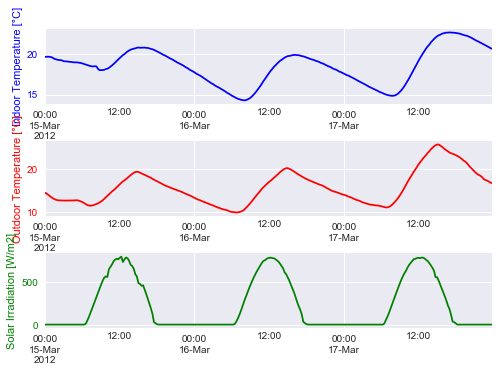

In [10]:
#First part:
SmallDatabase=ChosenData["2012-03-15":"2012-03-17"]
fig = plt.figure("From 2012-03-15 to 2012-03-17")
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3= fig.add_subplot(3,1,3)
SmallDatabase.iloc[:,0].plot(ax=ax1,legend=False,color="b")
SmallDatabase.iloc[:,1].plot(ax=ax2,legend=False,color="r")
SmallDatabase.iloc[:,2].plot(ax=ax3,legend=False,color="g")
ax1.set_ylabel("Indoor Temperature [°C]", color="b")
ax2.set_ylabel("Outdoor Temperature [°C]", color="r")
ax3.set_ylabel("Solar Irradiation [W/m2]", color="g")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax1.tick_params(axis='y',colors='b')
ax2.tick_params(axis='y',colors='r')
ax3.tick_params(axis='y',colors='g')
fig.subplots_adjust(hspace=0.5)
plt.show()


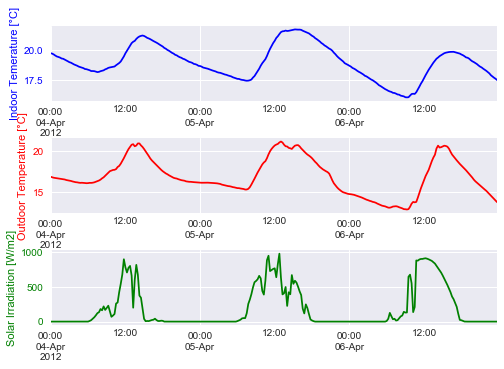

In [11]:
#Second part:
SmallDatabase1=ChosenData["2012-04-4":"2012-04-6"]
fig = plt.figure("From 2012-04-4 to 2012-04-6")
ax1_1 = fig.add_subplot(3,1,1)
ax2_1 = fig.add_subplot(3,1,2)
ax3_1 = fig.add_subplot(3,1,3)
SmallDatabase1.iloc[:,0].plot(ax=ax1_1,legend=False,color="b")
SmallDatabase1.iloc[:,1].plot(ax=ax2_1,legend=False,color="r")
SmallDatabase1.iloc[:,2].plot(ax=ax3_1,legend=False,color="g")
ax1_1.set_ylabel("Indoor Temerature [°C]", color="b")
ax2_1.set_ylabel("Outdoor Temperature [°C]", color="r")
ax3_1.set_ylabel("Solar Irradiation [W/m2]", color="g")
ax1_1.set_xlabel("")
ax2_1.set_xlabel("")
ax3_1.set_xlabel("")
ax1_1.tick_params(axis='y',colors='b')
ax2_1.tick_params(axis='y',colors='r')
ax3_1.tick_params(axis='y',colors='g')
fig.subplots_adjust(hspace=0.5)
plt.show()

From these two plots I can see that there's a periodical lag between the indoor temperature and the two other parameters, so I need to find a better correlation


In [12]:
Temperature_lag=ChosenData[["IndoorTemperature [°C]"]].join(ChosenData[["OutdoorTemperature [°C]"]])
Irradiance_lag=ChosenData[["IndoorTemperature [°C]"]].join(ChosenData[["SolarIrradiance [W/m2]"]])

Using the command .corr() applied to the database Temperature_lag, I find that the best correlation is achieved with a shift of 6 for the outdoor temperature. I can state this by looking to the Pearson's coefficients: the maximum value for this coefficient is reached with a shift of 6.


In [13]:
Temperature_lag=func.lag_column(Temperature_lag,"OutdoorTemperature [°C]",20)
Temperature_lag_corr = Temperature_lag.corr()
Temperature_lag_corr.head()

,IndoorTemperature [°C],OutdoorTemperature [°C],OutdoorTemperature [°C] -1hr,OutdoorTemperature [°C] -2hr,OutdoorTemperature [°C] -3hr,OutdoorTemperature [°C] -4hr,OutdoorTemperature [°C] -5hr,OutdoorTemperature [°C] -6hr,OutdoorTemperature [°C] -7hr,OutdoorTemperature [°C] -8hr,...,OutdoorTemperature [°C] -11hr,OutdoorTemperature [°C] -12hr,OutdoorTemperature [°C] -13hr,OutdoorTemperature [°C] -14hr,OutdoorTemperature [°C] -15hr,OutdoorTemperature [°C] -16hr,OutdoorTemperature [°C] -17hr,OutdoorTemperature [°C] -18hr,OutdoorTemperature [°C] -19hr,OutdoorTemperature [°C] -20hr
IndoorTemperature [°C],1.000000,0.863417,0.879529,0.892916,0.903545,0.911380,0.916406,0.918626,0.918076,0.914825,...,0.889657,0.876491,0.861164,0.843848,0.824698,0.803865,0.781494,0.757746,0.732785,0.706770
OutdoorTemperature [°C],0.863417,1.000000,0.997767,0.991546,0.981649,0.968143,0.951213,0.931029,0.907781,0.881744,...,0.789201,0.754252,0.717602,0.679526,0.640223,0.599910,0.558820,0.517161,0.475117,0.432916
OutdoorTemperature [°C] -1hr,0.879529,0.997767,1.000000,0.997767,0.991546,0.981649,0.968144,0.951217,0.931035,0.907789,...,0.822243,0.789225,0.754281,0.717635,0.679566,0.640267,0.599954,0.558865,0.517206,0.475166
OutdoorTemperature [°C] -2hr,0.892916,0.991546,0.997767,1.000000,0.997767,0.991546,0.981651,0.968148,0.951224,0.931045,...,0.853185,0.822268,0.789257,0.754317,0.717678,0.679614,0.640316,0.600004,0.558916,0.517260
OutdoorTemperature [°C] -3hr,0.903545,0.981649,0.991546,0.997767,1.000000,0.997767,0.991548,0.981655,0.968155,0.951233,...,0.881795,0.853210,0.822300,0.789292,0.754360,0.717727,0.679664,0.640366,0.600055,0.558970


While using the command .corr() applied to the database Irradiance_lag, I find that the best correlation is achieved with a shift of 19 for the solar irradiance.

In [14]:
Irradiance_lag=func.lag_column(Irradiance_lag,"SolarIrradiance [W/m2]",24)
Irradiance_lag_corr = Irradiance_lag.corr()
Irradiance_lag_corr.head()

,IndoorTemperature [°C],SolarIrradiance [W/m2],SolarIrradiance [W/m2] -1hr,SolarIrradiance [W/m2] -2hr,SolarIrradiance [W/m2] -3hr,SolarIrradiance [W/m2] -4hr,SolarIrradiance [W/m2] -5hr,SolarIrradiance [W/m2] -6hr,SolarIrradiance [W/m2] -7hr,SolarIrradiance [W/m2] -8hr,...,SolarIrradiance [W/m2] -15hr,SolarIrradiance [W/m2] -16hr,SolarIrradiance [W/m2] -17hr,SolarIrradiance [W/m2] -18hr,SolarIrradiance [W/m2] -19hr,SolarIrradiance [W/m2] -20hr,SolarIrradiance [W/m2] -21hr,SolarIrradiance [W/m2] -22hr,SolarIrradiance [W/m2] -23hr,SolarIrradiance [W/m2] -24hr
IndoorTemperature [°C],1.000000,0.123839,0.168439,0.211500,0.253125,0.293128,0.331181,0.367030,0.400453,0.431348,...,0.570311,0.578809,0.584620,0.587810,0.588470,0.586756,0.582799,0.576681,0.568466,0.558359
SolarIrradiance [W/m2],0.123839,1.000000,0.979704,0.956813,0.936922,0.913338,0.882852,0.846235,0.805748,0.761048,...,0.364188,0.303339,0.243010,0.182660,0.123298,0.065608,0.010643,-0.042610,-0.093036,-0.140146
SolarIrradiance [W/m2] -1hr,0.168439,0.979704,1.000000,0.979707,0.956824,0.936940,0.913354,0.882864,0.846243,0.805751,...,0.425703,0.364139,0.303283,0.242947,0.182589,0.123220,0.065524,0.010552,-0.042708,-0.093140
SolarIrradiance [W/m2] -2hr,0.211500,0.956813,0.979707,1.000000,0.979708,0.956826,0.936940,0.913351,0.882857,0.846231,...,0.487195,0.425631,0.364058,0.303192,0.242848,0.182482,0.123104,0.065399,0.010420,-0.042848
SolarIrradiance [W/m2] -3hr,0.253125,0.936922,0.956824,0.979708,1.000000,0.979705,0.956820,0.936931,0.913338,0.882838,...,0.547451,0.487109,0.425534,0.363950,0.303074,0.242720,0.182343,0.122955,0.065240,0.010251


In [15]:
#So:
ChosenData["Outdoor Temp Shifted"]=ChosenData["OutdoorTemperature [°C]"].shift(6)
ChosenData["Irradiance Shifted"]=ChosenData["SolarIrradiance [W/m2]"].shift(19)

The final database will be the following (cleaned from all the lines with NaNs):

In [16]:
ShiftedDatabase=ChosenData[["IndoorTemperature [°C]"]].join([ChosenData[["Outdoor Temp Shifted"]],ChosenData[["Irradiance Shifted"]]])
FinalDatabase=ShiftedDatabase.dropna()
FinalDatabase.head()

,IndoorTemperature [°C],Outdoor Temp Shifted,Irradiance Shifted
Timestamp,,,
2012-03-13 16:30:00,23.2000,22.1373,758.880
2012-03-13 16:45:00,23.4360,22.0800,762.069
2012-03-13 17:00:00,23.6680,21.9373,766.251
2012-03-13 17:15:00,23.8520,21.7067,766.037
2012-03-13 17:30:00,24.0213,21.4667,762.743


Now let's see the differences on a plot:

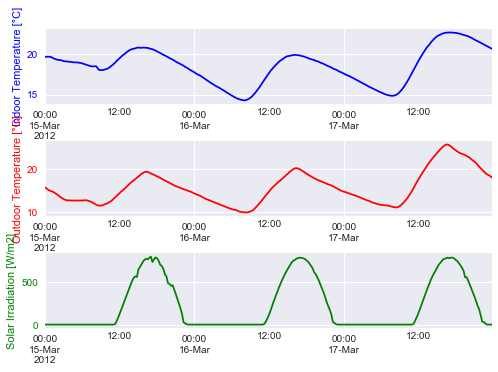

In [17]:
SmallDatabase2=FinalDatabase["2012-03-15":"2012-03-17"]
fig = plt.figure("From 2012-03-15 to 2012-03-17 SHIFTED")
ax1_2 = fig.add_subplot(3,1,1)
ax2_2 = fig.add_subplot(3,1,2)
ax3_2 = fig.add_subplot(3,1,3)
SmallDatabase2.iloc[:,0].plot(ax=ax1_2,legend=False,color="b")
SmallDatabase2.iloc[:,1].plot(ax=ax2_2,legend=False,color="r")
SmallDatabase2.iloc[:,2].plot(ax=ax3_2,legend=False,color="g")
ax1_2.set_ylabel("Indoor Temperature [°C]", color="b")
ax2_2.set_ylabel("Outdoor Temperature [°C]", color="r")
ax3_2.set_ylabel("Solar Irradiation [W/m2]", color="g")
ax1_2.set_xlabel("")
ax2_2.set_xlabel("")
ax3_2.set_xlabel("")
ax1_2.tick_params(axis='y',colors='b')
ax2_2.tick_params(axis='y',colors='r')
ax3_2.tick_params(axis='y',colors='g')
fig.subplots_adjust(hspace=0.5)
plt.show()

As observable from the plot, now we have a good correlation between the data: indeed the indoor temperature reaches its peak at the same time of outdoor temperature and solar irradiance.

So, the final Database, considering the best correlation between the data and cleaned from all the lines with NaNs is:

In [18]:
FinalDatabase_withLag = func.lag_column(FinalDatabase,"IndoorTemperature [°C]",24)
FinalDatabase_withLag.dropna(inplace=True)
FinalDatabase_withLag.head(24)

,IndoorTemperature [°C],Outdoor Temp Shifted,Irradiance Shifted,IndoorTemperature [°C] -1hr,IndoorTemperature [°C] -2hr,IndoorTemperature [°C] -3hr,IndoorTemperature [°C] -4hr,IndoorTemperature [°C] -5hr,IndoorTemperature [°C] -6hr,IndoorTemperature [°C] -7hr,...,IndoorTemperature [°C] -15hr,IndoorTemperature [°C] -16hr,IndoorTemperature [°C] -17hr,IndoorTemperature [°C] -18hr,IndoorTemperature [°C] -19hr,IndoorTemperature [°C] -20hr,IndoorTemperature [°C] -21hr,IndoorTemperature [°C] -22hr,IndoorTemperature [°C] -23hr,IndoorTemperature [°C] -24hr
Timestamp,,,,,,,,,,,,,,,,,,,,,
2012-03-13 22:30:00,20.4753,16.6853,15.57000,20.6600,20.8107,20.9813,21.1480,21.3480,21.5373,21.7133,...,23.5880,24.0707,24.3800,24.2680,24.1413,24.0213,23.8520,23.6680,23.4360,23.2000
2012-03-13 22:45:00,20.3147,16.4160,5.00933,20.4753,20.6600,20.8107,20.9813,21.1480,21.3480,21.5373,...,23.2867,23.5880,24.0707,24.3800,24.2680,24.1413,24.0213,23.8520,23.6680,23.4360
2012-03-13 23:00:00,20.1640,16.2200,0.00000,20.3147,20.4753,20.6600,20.8107,20.9813,21.1480,21.3480,...,23.0320,23.2867,23.5880,24.0707,24.3800,24.2680,24.1413,24.0213,23.8520,23.6680
2012-03-13 23:15:00,19.9967,16.0547,0.00000,20.1640,20.3147,20.4753,20.6600,20.8107,20.9813,21.1480,...,22.7747,23.0320,23.2867,23.5880,24.0707,24.3800,24.2680,24.1413,24.0213,23.8520
2012-03-13 23:30:00,19.8460,15.8760,0.00000,19.9967,20.1640,20.3147,20.4753,20.6600,20.8107,20.9813,...,22.5533,22.7747,23.0320,23.2867,23.5880,24.0707,24.3800,24.2680,24.1413,24.0213
2012-03-13 23:45:00,19.6773,15.7213,0.00000,19.8460,19.9967,20.1640,20.3147,20.4753,20.6600,20.8107,...,22.3520,22.5533,22.7747,23.0320,23.2867,23.5880,24.0707,24.3800,24.2680,24.1413
2012-03-14 00:00:00,19.5260,15.5673,0.00000,19.6773,19.8460,19.9967,20.1640,20.3147,20.4753,20.6600,...,22.1227,22.3520,22.5533,22.7747,23.0320,23.2867,23.5880,24.0707,24.3800,24.2680
2012-03-14 00:15:00,19.3733,15.4147,0.00000,19.5260,19.6773,19.8460,19.9967,20.1640,20.3147,20.4753,...,21.9347,22.1227,22.3520,22.5533,22.7747,23.0320,23.2867,23.5880,24.0707,24.3800
2012-03-14 00:30:00,19.2087,15.2600,0.00000,19.3733,19.5260,19.6773,19.8460,19.9967,20.1640,20.3147,...,21.7133,21.9347,22.1227,22.3520,22.5533,22.7747,23.0320,23.2867,23.5880,24.0707


Now I define two dataframes, one with the target data (indoor temperature) and the other one with the features

In [19]:
Target=FinalDatabase_withLag["IndoorTemperature [°C]"] #this is the dataframe with the dependent variable (indoor temperature)
Features=FinalDatabase_withLag.drop("IndoorTemperature [°C]",axis=1)# this is the dataframe with the variables the indoor temperature depends on

This is the function that allows me to normalize a value taken in input

In [20]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

The two dataframes normalized are:

In [21]:
#Target normalized:
TargetNorm=func.normalize(Target)
TargetNorm.head()

Timestamp
2012-03-13 22:30:00    0.677769
2012-03-13 22:45:00    0.666188
2012-03-13 23:00:00    0.655322
2012-03-13 23:15:00    0.643258
2012-03-13 23:30:00    0.632391
Name: IndoorTemperature [Â°C], dtype: float64

In [22]:
#Features normalized:
FeaturesNorm=func.normalize(Features)
FeaturesNorm.head()

,Outdoor Temp Shifted,Irradiance Shifted,IndoorTemperature [°C] -1hr,IndoorTemperature [°C] -2hr,IndoorTemperature [°C] -3hr,IndoorTemperature [°C] -4hr,IndoorTemperature [°C] -5hr,IndoorTemperature [°C] -6hr,IndoorTemperature [°C] -7hr,IndoorTemperature [°C] -8hr,...,IndoorTemperature [°C] -15hr,IndoorTemperature [°C] -16hr,IndoorTemperature [°C] -17hr,IndoorTemperature [°C] -18hr,IndoorTemperature [°C] -19hr,IndoorTemperature [°C] -20hr,IndoorTemperature [°C] -21hr,IndoorTemperature [°C] -22hr,IndoorTemperature [°C] -23hr,IndoorTemperature [°C] -24hr
Timestamp,,,,,,,,,,,,,,,,,,,,,
2012-03-13 22:30:00,0.360749,0.015142,0.691087,0.701954,0.714256,0.726276,0.740698,0.754348,0.767039,0.783004,...,0.902221,0.937028,0.959331,0.951255,0.942119,0.933466,0.921258,0.907990,0.891260,0.874243
2012-03-13 22:45:00,0.347730,0.004872,0.677769,0.691087,0.701954,0.714256,0.726276,0.740698,0.754348,0.767039,...,0.880495,0.902221,0.937028,0.959331,0.951255,0.942119,0.933466,0.921258,0.907990,0.891260
2012-03-13 23:00:00,0.338254,0.000000,0.666188,0.677769,0.691087,0.701954,0.714256,0.726276,0.740698,0.754348,...,0.862129,0.880495,0.902221,0.937028,0.959331,0.951255,0.942119,0.933466,0.921258,0.907990
2012-03-13 23:15:00,0.330262,0.000000,0.655322,0.666188,0.677769,0.691087,0.701954,0.714256,0.726276,0.740698,...,0.843575,0.862129,0.880495,0.902221,0.937028,0.959331,0.951255,0.942119,0.933466,0.921258
2012-03-13 23:30:00,0.321623,0.000000,0.643258,0.655322,0.666188,0.677769,0.691087,0.701954,0.714256,0.726276,...,0.827610,0.843575,0.862129,0.880495,0.902221,0.937028,0.959331,0.951255,0.942119,0.933466


# Regression model

Let's begin with the linear regression model:

In [23]:
#The function train_test_split splits arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

Here I created two dataframes for the features (one to train the model and one to test it) and two for the target of the regession

In [24]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Features, Target, test_size=0.2, random_state=41234) 
#They are the same dataframes but normalized
XtrainNorm, XtestNorm, YtrainNorm, YtestNorm = train_test_split(FeaturesNorm, TargetNorm, test_size=0.2, random_state=41234)

In [25]:
from sklearn import linear_model
linear_reg = linear_model.LinearRegression() 
linear_reg.fit(Xtrain, Ytrain)

LinearRegSplitPred= linear_reg.predict(Xtest)
LinearRegSplitPredDF=pd.DataFrame(LinearRegSplitPred, index = Ytest.index,columns=["IndoorTempPrediction"])

LinearRegSplitPredDF = LinearRegSplitPredDF.join(Ytest)

This is a plot with the comparison between the actual values and the predicted ones

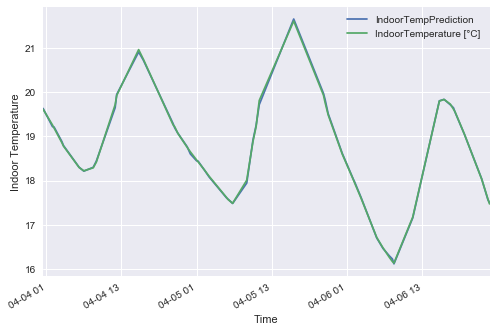

In [26]:
LinearRegSplitPredDF["2012-04-4":"2012-04-6"].plot()
plt.xlabel("Time")
plt.ylabel("Indoor Temperature")
plt.show()

Now I calculate the Rsquare,the mean absolute error and the mean squared error in order to verify the goodness of the model with the function Accuracy

In [27]:
#This function allows to determine Rsquare, MSE, MAE and the coefficient of variation

def Accuracy(df,ActualValues,PredictedValues,Model):
    #df ==> DataFrame
    #ActualValues ==> name of the column of the dataframe containing the measured values
    #PredictedValues ==> name of the column of the dataframe containing the predicted values
    #Model ==> type of model (linear regression, cross validation, support vector machines, random forest regressor)
    from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
    Rsquare=r2_score(df[ActualValues],df[PredictedValues])
    MAE=mean_absolute_error(df[ActualValues],df[PredictedValues])
    MSE=mean_squared_error(df[ActualValues],df[PredictedValues])
    CoeffVar=np.sqrt(MSE)/df[ActualValues].mean()
    Values={"Rsquare":Rsquare,"MAE":MAE,"MSE":MSE,"Coefficient Variation":CoeffVar}
    print ("Rsquare for "+Model+": "+str(Rsquare))
    print ("Mean absolute error for "+Model+": "+str(MAE))
    print ("Mean squared error for "+Model+": "+str(MSE))
    print ("Coeffcient of variation for "+Model+": "+str(CoeffVar))
    return Values

In [28]:
AccuracyLinReg=func.Accuracy(LinearRegSplitPredDF,"IndoorTemperature [°C]","IndoorTempPrediction","linear regression")

Here the respective values of Mean absolute error, Mean squared error and Rsquare using the Linear Regression model are listed:

The partition of the available data into three sets drastically reduces the number of samples that can be used for training the model. To see if the model is good under this point of view, we use a procedure called "cross validation"


In [29]:
from sklearn.model_selection import cross_val_predict
CVpredict = cross_val_predict(linear_reg,Features,Target,cv=10)
CVpredictDF=pd.DataFrame(CVpredict, index = Target.index,columns=["IndoorTempPredictCV"])

CVpredictDF = CVpredictDF.join(Target)
CVpredictDF.head()

,IndoorTempPredictCV,IndoorTemperature [°C]
Timestamp,,
2012-03-13 22:30:00,20.527890,20.4753
2012-03-13 22:45:00,20.361619,20.3147
2012-03-13 23:00:00,20.216856,20.1640
2012-03-13 23:15:00,20.039223,19.9967
2012-03-13 23:30:00,19.844738,19.8460


Now we trace the trend of actual indoor temperature vs predicted indoor temperature:

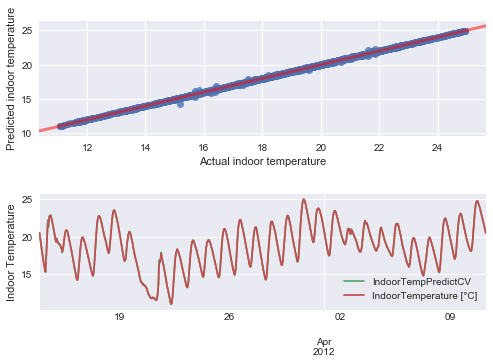

In [30]:
fig = plt.figure('Actual indoor temperature vs predicted indoor temperature')
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
plot=sns.regplot(x="IndoorTemperature [°C]", y="IndoorTempPredictCV",data=CVpredictDF,ax=ax1,line_kws={"lw":3,"alpha":0.5})
plot.set_xlabel("Actual indoor temperature")
plot.set_ylabel("Predicted indoor temperature")
regline = plot.get_lines()[0]
regline.set_color('r')
CVpredictDF.plot(ax=ax2)
plt.xlabel("")
plt.ylabel("Indoor Temperature")
fig.subplots_adjust(hspace=0.5,bottom=0.15)

AccuracyCV=func.Accuracy(CVpredictDF,"IndoorTemperature [°C]","IndoorTempPredictCV","cross validation")
plt.show()

Here the respective values of Mean absolute error, Mean squared error and Rsquare using the Cross Validation model are listed:

Now I use the Support Vector Machines:

In [31]:
from sklearn.svm import SVR
SVR_reg = SVR(kernel='rbf',C=10,gamma=1)
PredictSVR_CV = cross_val_predict(SVR_reg,FeaturesNorm,TargetNorm,cv=10)
PredictDF_SVR_CV=pd.DataFrame(PredictSVR_CV, index = TargetNorm.index,columns=["IndoorTempNormSVR"])
PredictDF_SVR_CV = PredictDF_SVR_CV.join(TargetNorm)
PredictDF_SVR_CV=PredictDF_SVR_CV.dropna()
PredictDF_SVR_CV.head()

,IndoorTempNormSVR,IndoorTemperature [°C]
Timestamp,,
2012-03-13 22:30:00,0.703151,0.677769
2012-03-13 22:45:00,0.691460,0.666188
2012-03-13 23:00:00,0.681033,0.655322
2012-03-13 23:15:00,0.671666,0.643258
2012-03-13 23:30:00,0.662727,0.632391


Now we trace the trend of actual indoor temperature vs predicted indoor temperature normalized:

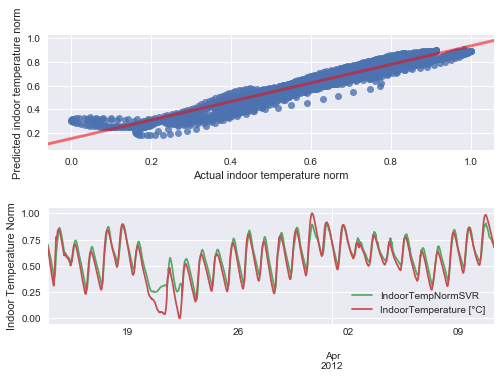

In [32]:
fig = plt.figure('Actual indoor temperature norm vs predicted indoor temperature norm')
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
plot=sns.regplot(x="IndoorTemperature [°C]", y="IndoorTempNormSVR",data=PredictDF_SVR_CV,ax=ax1,line_kws={"lw":3,"alpha":0.5})
plot.set_xlabel("Actual indoor temperature norm")
plot.set_ylabel("Predicted indoor temperature norm")
regline = plot.get_lines()[0]
regline.set_color('r')
PredictDF_SVR_CV.plot(ax=ax2)
plt.xlabel("")
plt.ylabel("Indoor Temperature Norm")
fig.subplots_adjust(hspace=0.5,bottom=0.15)

AccuracySVR=func.Accuracy(PredictDF_SVR_CV,"IndoorTemperature [°C]","IndoorTempNormSVR","support vector machines")
plt.show()

Here the respective values of Mean absolute error, Mean squared error and Rsquare using the Support Vector Machines model are listed:

As can be seen, in this case the value of Rsquare has drastically decreased compared to that calculated with the Linear Regression model and the Cross Validation model.

Random Forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size

In [33]:
from sklearn.ensemble import RandomForestRegressor
reg_RF = RandomForestRegressor()
PredictRF_CV = cross_val_predict(reg_RF,Features,Target,cv=10)
PredictDF_RF_CV=pd.DataFrame(PredictRF_CV,index=Target.index,columns=["IndoorTempRF"])
PredictDF_RF_CV = PredictDF_RF_CV.join(Target)
PredictDF_RF_CV=PredictDF_RF_CV.dropna()
PredictDF_RF_CV.head()

,IndoorTempRF,IndoorTemperature [°C]
Timestamp,,
2012-03-13 22:30:00,20.59267,20.4753
2012-03-13 22:45:00,20.37687,20.3147
2012-03-13 23:00:00,20.20746,20.1640
2012-03-13 23:15:00,20.03919,19.9967
2012-03-13 23:30:00,19.92124,19.8460


Now we trace the trend of actual indoor temperature vs predicted indoor temperature with RandomForestRegressor:

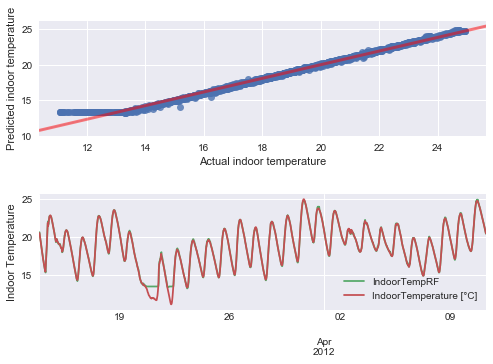

In [34]:
fig = plt.figure('Actual indoor temperature vs predicted indoor temperature with RandomForestRegressor')
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
plot=sns.regplot(x="IndoorTemperature [°C]", y="IndoorTempRF",data=PredictDF_RF_CV,ax=ax1,line_kws={"lw":3,"alpha":0.5})
plot.set_xlabel("Actual indoor temperature")
plot.set_ylabel("Predicted indoor temperature")
regline = plot.get_lines()[0]
regline.set_color('r')
PredictDF_RF_CV.plot(ax=ax2)
plt.xlabel("")
plt.ylabel("Indoor Temperature")
fig.subplots_adjust(hspace=0.5,bottom=0.15)

AccuracyRF=func.Accuracy(PredictDF_RF_CV,"IndoorTemperature [°C]","IndoorTempRF","random forest regressor")
plt.show()

Here the respective values of Mean absolute error, Mean squared error and Rsquare using the Random Forest Regressor are listed:

Finally, after analyzing the four linear regression models we can conclude that the best to use is definitely the Cross Validation model, presenting a Rsquare greater and Mean absolute error and Mean squared error lower than the others.